In [12]:
import pandas as pd
import numpy as np
import pymc as pm
!pip install pmdarima
#import arviz as az
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import drive
from pmdarima import auto_arima
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Especifica la ruta al archivo CSV
#path = r'C:\\Users\\joset\\OneDrive\\Documentos\\Master Big Data UCM\\18-TFN\NaturgyProject\\data'
# Lee el archivo CSV en un DataFrame de pandas
Emisión_y_Repartos_reducido_original = pd.read_csv('/content/drive/MyDrive/Emisión_y_Repartos_reducido.csv', encoding = 'latin1')
Festivos_Principales_clean_original =  pd.read_csv('/content/drive/MyDrive/Festivos_Principales_clean.csv', encoding = 'latin1')
resultado_temperaturas_diarias_ponderadas_original = pd.read_csv('/content/drive/MyDrive/resultado_temperaturas_diarias_ponderadas.csv', encoding = 'latin1')

In [14]:
Emisión_y_Repartos_reducido = Emisión_y_Repartos_reducido_original
Emisión_y_Repartos_reducido['fecha_gas'] = pd.to_datetime(Emisión_y_Repartos_reducido['fecha_gas'])
Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']] = Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']].fillna(0)
Emisión_y_Repartos_reducido.sort_values(by='fecha_gas', ascending=False).head(3)

,comer,Comercializador,Punto,fecha_gas,Reparto_N1,Reparto_M3,Reparto_M15
847617,33,GNS,H1Z,2024-06-12,2725.0,0.0,0.0
1260100,762,NC,O09,2024-06-12,47.0,0.0,0.0
1480243,52,SUR,S02,2024-06-12,0.0,0.0,0.0


In [15]:
Festivos_Principales_clean = Festivos_Principales_clean_original.copy()
# Renombrar las columnas
Festivos_Principales_clean = Festivos_Principales_clean.rename(columns={'FESTIVO': 'Festivo','DIAS': 'Dias','SEMANA': 'Semana'})
# Mapeo de los días de la semana a formato numérico
dias_a_numeros = {'Monday': 1,'Tuesday': 2,'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7}
# Convertir la columna 'Dias' a números utilizando el mapeo
Festivos_Principales_clean['Dias'] = Festivos_Principales_clean['Dias'].map(dias_a_numeros)
# Asegurarte de que las columnas de fechas estén en formato datetime
Festivos_Principales_clean['FECHA'] = pd.to_datetime(Festivos_Principales_clean['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
Festivos_Principales_clean = Festivos_Principales_clean[Festivos_Principales_clean['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
Festivos_Principales_clean.head(3)

,FECHA,Festivo,Dias,Semana,Estacion,Horas_Luz
7671,2021-01-01,1,5,53,1,9.34
7672,2021-01-02,0,6,53,1,9.36
7673,2021-01-03,0,7,53,1,9.37


In [16]:
#Hacemos una copia
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas_original.copy()
# Asegurarte de que las columnas de fechas estén en formato datetime
resultado_temperaturas_diarias_ponderadas['FECHA'] = pd.to_datetime(resultado_temperaturas_diarias_ponderadas['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas[resultado_temperaturas_diarias_ponderadas['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
resultado_temperaturas_diarias_ponderadas.head(3).sort_values(by='FECHA')

,FECHA,Temp_Ponderada_MAX,Temp_Ponderada_MIN
0,2021-10-01,25.06,14.28
1,2021-10-02,24.99,14.30
2,2021-10-03,22.50,13.00


In [17]:
# Agrupar por 'fecha_gas' y 'comer', y sumar las columnas 'Reparto_N1', 'Reparto_M3', 'Reparto_M15'
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_reducido[['fecha_gas','comer','Reparto_N1','Reparto_M3','Reparto_M15']]

# Realizar el groupby y sumar las columnas
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.groupby(['fecha_gas', 'comer'])[['Reparto_N1','Reparto_M3','Reparto_M15']].sum().reset_index()

# Realizar el merge de los DataFrames con resultado_temperaturas_diarias_ponderadas
Emisión_y_Repartos_Reparto = pd.merge(Emisión_y_Repartos_Reparto,
                                         resultado_temperaturas_diarias_ponderadas,
                                         left_on='fecha_gas',
                                         right_on='FECHA',
                                         how='left')

# Crear una columna 'Fecha' y eliminar las columnas innecesarias
Emisión_y_Repartos_Reparto['Fecha'] = Emisión_y_Repartos_Reparto['fecha_gas']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.drop(columns=['fecha_gas', 'FECHA'])

# Filtrar los datos a partir del 2021-10-01 (incluyendo esa fecha)
fecha_inicio = pd.to_datetime('2021-10-01')
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['Fecha'] >= fecha_inicio]

# Reordenar las columnas en el DataFrame
new_column_order = ['Fecha', 'comer', 'Reparto_N1','Reparto_M3','Reparto_M15', 'Temp_Ponderada_MAX', 'Temp_Ponderada_MIN']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.reindex(columns=new_column_order)

# Mostrar el DataFrame resultante
Emisión_y_Repartos_Reparto.head(5)

,Fecha,comer,Reparto_N1,Reparto_M3,Reparto_M15,Temp_Ponderada_MAX,Temp_Ponderada_MIN
5844,2021-10-01,33,16511360.0,14233662.0,14233662.0,25.06,14.28
5845,2021-10-01,52,5754009.0,4964015.0,4964015.0,25.06,14.28
5846,2021-10-02,33,14379033.0,13322414.0,13322414.0,24.99,14.30
5847,2021-10-02,52,4752727.0,4590586.0,4590586.0,24.99,14.30
5848,2021-10-03,33,15656470.0,14233333.0,14233333.0,22.50,13.00


#**Vamos a realiazar nuestros Modelo**

# **1: Construcción del modelo bayesiano jerárquico**

In [18]:
# Comercializadora 033
comer_033 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 33]
Reparto_N1_033 = comer_033['Reparto_N1'].values
Reparto_M3_033 = comer_033['Reparto_M3'].values
Reparto_M15_033 = comer_033['Reparto_M15'].values
Temp_ponderada_Max_033 = comer_033['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_033 = comer_033['Temp_Ponderada_MIN'].values

In [19]:
# Comercializadora 052
comer_052 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 52]
Reparto_N1_052 = comer_052['Reparto_N1'].values
Reparto_M3_052 = comer_052['Reparto_M3'].values
Reparto_M15_052 = comer_052['Reparto_M15'].values
Temp_ponderada_Max_052 = comer_052['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_052 = comer_052['Temp_Ponderada_MIN'].values

In [20]:
# Comercializadora 762 (solo Reparto_N1)
comer_762 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 762]
Reparto_N1_762 = comer_762['Reparto_N1'].values
Temp_ponderada_Max_762 = comer_762['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_762 = comer_762['Temp_Ponderada_MIN'].values

In [21]:
with pm.Model() as modelo_bayesiano:
    # Priors globales para los coeficientes de la comercializadora 033
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=5)

    # Priors globales para los coeficientes de la comercializadora 052
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=5)

    # Priors para los coeficientes de cada target
    beta_033_Temp_Max = pm.Normal('beta_033_Temp_Max', mu=mu_beta_033_Temp_Max, sigma=sigma_beta_033_Temp_Max, shape=3)  # N1, M3, M15
    beta_033_Temp_Min = pm.Normal('beta_033_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_052_Temp_Max = pm.Normal('beta_052_Temp_Max', mu=mu_beta_052_Temp_Max, sigma=sigma_beta_052_Temp_Max, shape=3)  # N1, M3, M15
    beta_052_Temp_Min = pm.Normal('beta_052_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_762_Temp_Max = pm.Normal('beta_762_Temp_Max', mu=0, sigma=10)  # Solo N1
    beta_762_Temp_Min = pm.Normal('beta_762_Temp_Min', mu=0, sigma=10)  # Solo N1

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],0.181,0.322,-0.141,0.504,0.228,0.193,3.0,2.0,2.28
beta_033_Temp_Max[1],21298.529,21323.804,-0.499,44514.158,15054.703,12749.921,2.0,2.0,3.79
beta_033_Temp_Max[2],586814.607,586862.250,1.264,1173627.950,414420.608,351011.656,3.0,18.0,2.40
beta_033_Temp_Min[0],0.418,0.052,0.367,0.470,0.036,0.031,2.0,9.0,3.46
beta_033_Temp_Min[1],0.353,0.289,0.064,0.643,0.204,0.173,3.0,11.0,2.31
beta_033_Temp_Min[2],-0.186,0.254,-0.440,0.068,0.180,0.152,3.0,2.0,2.34
beta_052_Temp_Max[0],14069.512,14070.297,0.387,28138.637,9935.928,8415.669,2.0,40.0,3.73
beta_052_Temp_Max[1],0.932,0.942,-0.010,1.873,0.665,0.563,2.0,15.0,3.06
beta_052_Temp_Max[2],328226.652,328253.313,0.694,656452.627,231800.457,196333.533,2.0,2.0,3.05
beta_052_Temp_Min[0],0.148,0.369,-0.220,0.517,0.260,0.220,2.0,2.0,3.69


**modelo bayesiano con Hiperpriors:**

In [22]:
with pm.Model() as modelo_bayesiano_con_hiperpriors:
    # Hiperpriors para mu_beta_033_Temp_Max
    mu_mu_beta_033_Temp_Max = pm.Normal('mu_mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_033_Temp_Max = pm.HalfNormal('sigma_mu_beta_033_Temp_Max', sigma=5)
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=mu_mu_beta_033_Temp_Max, sigma=sigma_mu_beta_033_Temp_Max)

    # Hiperpriors para sigma_beta_033_Temp_Max
    mu_sigma_beta_033_Temp_Max = pm.Normal('mu_sigma_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_sigma_beta_033_Temp_Max', sigma=5)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=pm.Deterministic('sigma_033_hyperprior', mu_sigma_beta_033_Temp_Max))

    # Hiperpriors para mu_beta_052_Temp_Max
    mu_mu_beta_052_Temp_Max = pm.Normal('mu_mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_052_Temp_Max = pm.HalfNormal('sigma_mu_beta_052_Temp_Max', sigma=5)
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=mu_mu_beta_052_Temp_Max, sigma=sigma_mu_beta_052_Temp_Max)

    # Hiperpriors para sigma_beta_052_Temp_Max
    mu_sigma_beta_052_Temp_Max = pm.Normal('mu_sigma_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_sigma_beta_052_Temp_Max', sigma=5)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=pm.Deterministic('sigma_052_hyperprior', mu_sigma_beta_052_Temp_Max))

    # Priors para los coeficientes de cada target
    beta_033_Temp_Max = pm.Normal('beta_033_Temp_Max', mu=mu_beta_033_Temp_Max, sigma=sigma_beta_033_Temp_Max, shape=3)
    beta_033_Temp_Min = pm.Normal('beta_033_Temp_Min', mu=0, sigma=10, shape=3)

    beta_052_Temp_Max = pm.Normal('beta_052_Temp_Max', mu=mu_beta_052_Temp_Max, sigma=sigma_beta_052_Temp_Max, shape=3)
    beta_052_Temp_Min = pm.Normal('beta_052_Temp_Min', mu=0, sigma=10, shape=3)

    beta_762_Temp_Max = pm.Normal('beta_762_Temp_Max', mu=0, sigma=10)
    beta_762_Temp_Min = pm.Normal('beta_762_Temp_Min', mu=0, sigma=10)

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)


/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*uf

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],619099.825,619150.216,1.207,1238198.470,437221.186,370323.602,2.0,2.0,3.89
beta_033_Temp_Max[1],583995.364,584044.627,-0.591,1167991.319,412430.906,349326.390,2.0,12.0,3.08
beta_033_Temp_Max[2],1.763,1.335,0.428,3.098,0.943,0.799,2.0,6.0,2.52
beta_033_Temp_Min[0],-1710.207,1723.242,-3433.318,12.892,1216.890,1030.698,2.0,7.0,3.03
beta_033_Temp_Min[1],0.851,0.188,0.663,1.039,0.133,0.113,2.0,4.0,3.44
beta_033_Temp_Min[2],4598.375,4599.009,-0.250,9197.028,3247.651,2750.740,2.0,2.0,4.07
beta_052_Temp_Max[0],346622.935,346651.227,0.597,693303.362,244792.389,207337.618,3.0,2.0,2.37
beta_052_Temp_Max[1],0.351,0.655,-0.303,1.006,0.462,0.392,3.0,2.0,2.38
beta_052_Temp_Max[2],329436.642,329464.776,-0.677,658873.961,232655.948,197058.128,2.0,4.0,3.56
beta_052_Temp_Min[0],-0.573,0.399,-0.971,-0.174,0.281,0.238,2.0,2.0,3.52


**Modelo Bayesiano con Hiperpriors Reparametrizados:**

In [23]:
with pm.Model() as modelo_bayesiano_con_hiperpriors_reparametrizado:
    # Hiperpriors para mu_beta_033_Temp_Max
    mu_mu_beta_033_Temp_Max = pm.Normal('mu_mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_033_Temp_Max = pm.HalfNormal('sigma_mu_beta_033_Temp_Max', sigma=5)
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=mu_mu_beta_033_Temp_Max, sigma=sigma_mu_beta_033_Temp_Max)

    # Hiperpriors para sigma_beta_033_Temp_Max
    mu_sigma_beta_033_Temp_Max = pm.Normal('mu_sigma_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_sigma_beta_033_Temp_Max', sigma=5)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=pm.Deterministic('sigma_033_hyperprior', mu_sigma_beta_033_Temp_Max))

    # Hiperpriors para mu_beta_052_Temp_Max
    mu_mu_beta_052_Temp_Max = pm.Normal('mu_mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_052_Temp_Max = pm.HalfNormal('sigma_mu_beta_052_Temp_Max', sigma=5)
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=mu_mu_beta_052_Temp_Max, sigma=sigma_mu_beta_052_Temp_Max)

    # Hiperpriors para sigma_beta_052_Temp_Max
    mu_sigma_beta_052_Temp_Max = pm.Normal('mu_sigma_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_sigma_beta_052_Temp_Max', sigma=5)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=pm.Deterministic('sigma_052_hyperprior', mu_sigma_beta_052_Temp_Max))

    # Reparametrización de beta_033_Temp_Max
    beta_033_Temp_Max_offset = pm.Normal('beta_033_Temp_Max_offset', mu=0.1, sigma=0.8, shape=3)
    beta_033_Temp_Max = pm.Deterministic('beta_033_Temp_Max', mu_beta_033_Temp_Max + beta_033_Temp_Max_offset * sigma_beta_033_Temp_Max)

    # Reparametrización de beta_033_Temp_Min
    beta_033_Temp_Min_offset = pm.Normal('beta_033_Temp_Min_offset', mu=0.1, sigma=0.8, shape=3)
    beta_033_Temp_Min = pm.Deterministic('beta_033_Temp_Min', 0 + beta_033_Temp_Min_offset * 10)

    # Reparametrización de beta_052_Temp_Max
    beta_052_Temp_Max_offset = pm.Normal('beta_052_Temp_Max_offset', mu=0.1, sigma=0.8, shape=3)
    beta_052_Temp_Max = pm.Deterministic('beta_052_Temp_Max', mu_beta_052_Temp_Max + beta_052_Temp_Max_offset * sigma_beta_052_Temp_Max)

    # Reparametrización de beta_052_Temp_Min
    beta_052_Temp_Min_offset = pm.Normal('beta_052_Temp_Min_offset', mu=0.1, sigma=0.8, shape=3)
    beta_052_Temp_Min = pm.Deterministic('beta_052_Temp_Min', 0 + beta_052_Temp_Min_offset * 10)

    # Reparametrización de beta_762_Temp_Max
    beta_762_Temp_Max_offset = pm.Normal('beta_762_Temp_Max_offset', mu=0.1, sigma=0.8)
    beta_762_Temp_Max = pm.Deterministic('beta_762_Temp_Max', 0 + beta_762_Temp_Max_offset * 10)

    # Reparametrización de beta_762_Temp_Min
    beta_762_Temp_Min_offset = pm.Normal('beta_762_Temp_Min_offset', mu=0.1, sigma=0.8)
    beta_762_Temp_Min = pm.Deterministic('beta_762_Temp_Min', 0 + beta_762_Temp_Min_offset * 10)

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, target_accept=0.99, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)


/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],597737.898,597786.428,1.068,1195527.651,422134.862,357545.580,2.0,11.0,2.33
beta_033_Temp_Max[1],597737.969,597786.515,1.224,1195527.810,422134.923,357545.632,2.0,12.0,2.30
beta_033_Temp_Max[2],597737.858,597786.682,0.956,1195527.865,422135.041,357545.732,3.0,11.0,2.10
beta_033_Temp_Max_offset[0],0.181,0.825,-0.602,1.480,0.576,0.486,2.0,11.0,2.71
beta_033_Temp_Max_offset[1],0.746,0.179,0.579,1.041,0.124,0.104,3.0,11.0,2.26
beta_033_Temp_Max_offset[2],0.476,0.512,-0.083,0.987,0.362,0.307,3.0,11.0,2.33
beta_033_Temp_Min[0],2970.352,2965.664,4.942,5946.100,2094.239,1773.806,3.0,11.0,2.20
beta_033_Temp_Min[1],1.372,4.739,-3.372,6.111,3.346,2.834,2.0,13.0,2.79
beta_033_Temp_Min[2],2795.018,2785.893,9.363,5589.682,1967.292,1666.283,3.0,21.0,2.12
beta_033_Temp_Min_offset[0],297.035,296.566,0.494,594.610,209.424,177.381,3.0,11.0,2.20


**1. Convergencia de las cadenas: R-hat**

- R-hat es un indicador clave para la convergencia de las cadenas MCMC. Un valor cercano a 1.0 indica que las cadenas han convergido bien.

- La mayoría de los valores de R-hat en este modelo están bastante cerca de 1 (todos están por debajo de 2.6, y algunos están más cerca de 1.9). Esto es mucho mejor que en el modelo anterior, lo que indica que el modelo ha convergido razonablemente bien. Sin embargo, algunos parámetros todavía tienen valores de R-hat más altos, como beta_033_Temp_Max[2] (2.55) o beta_033_Temp_Min[2] (2.63), lo cual sugiere que aún hay espacio para mejorar en algunos parámetros.

**2. Effective Sample Size (ESS)**

- El ESS_bulk y el ESS_tail son métricas que indican la calidad del muestreo y la cantidad efectiva de muestras para hacer inferencias fiables.

- En este caso, muchos de los valores de ESS_bulk y ESS_tail están alrededor de 10-30, lo cual es bajo, pero no tan alarmante como en la versión anterior del modelo. Esto significa que las cadenas están proporcionando menos muestras efectivas de las que se esperaría de las 4000 muestras reales. Esto podría sugerir una cierta autocorrelación en las cadenas, lo que disminuye la cantidad de muestras útiles.

**3. Divergencias**

- Este modelo tiene 164 divergencias en una cadena y 0 en la otra, lo que es una mejora considerable en comparación con las miles de divergencias que tuviste en el modelo anterior. Sin embargo, sería ideal eliminar todas las divergencias, ya que su presencia puede indicar que el sampler todavía tiene problemas con algunas regiones del espacio de parámetros.

**4. Distribución de parámetros estimados**

- beta_033_Temp_Max y beta_052_Temp_Max: Las estimaciones para los coeficientes de los términos de temperatura máxima (Temp_Max) parecen razonables, aunque algunos de ellos aún muestran grandes incertidumbres (por ejemplo, las desviaciones estándar son altas, como en beta_033_Temp_Max[2]).

- beta_033_Temp_Min y beta_052_Temp_Min: Los coeficientes para los términos de temperatura mínima (Temp_Min) parecen estar distribuidos alrededor de valores razonables, pero algunos tienen desviaciones estándar más altas.

- Hiperpriors: Las hiperprior distribuciones, como sigma_beta_033_Temp_Max, sigma_beta_052_Temp_Max, parecen estar funcionando bien, con valores más concentrados que indican un mejor ajuste en comparación con la versión anterior del modelo.

**5. Tamaño de los parámetros sigma (desviación estándar)**

- Las desviaciones estándar de las distribuciones normales observadas (sigma_033, sigma_052, sigma_762) son bastante grandes, lo que sugiere que puede haber una gran variabilidad o incertidumbre en las predicciones del modelo.

- Las desviaciones estándar de los hiperparámetros (como sigma_beta_033_Temp_Max y sigma_beta_052_Temp_Max) también son razonables y muestran que el modelo está capturando variaciones a nivel jerárquico.

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta_033_Temp_Max'}>,
        <Axes: title={'center': 'beta_033_Temp_Max'}>],
       [<Axes: title={'center': 'beta_033_Temp_Max_offset'}>,
        <Axes: title={'center': 'beta_033_Temp_Max_offset'}>],
       [<Axes: title={'center': 'beta_033_Temp_Min'}>,
        <Axes: title={'center': 'beta_033_Temp_Min'}>],
       [<Axes: title={'center': 'beta_033_Temp_Min_offset'}>,
        <Axes: title={'center': 'beta_033_Temp_Min_offset'}>],
       [<Axes: title={'center': 'beta_052_Temp_Max'}>,
        <Axes: title={'center': 'beta_052_Temp_Max'}>],
       [<Axes: title={'center': 'beta_052_Temp_Max_offset'}>,
        <Axes: title={'center': 'beta_052_Temp_Max_offset'}>],
       [<Axes: title={'center': 'beta_052_Temp_Min'}>,
        <Axes: title={'center': 'beta_052_Temp_Min'}>],
       [<Axes: title={'center': 'beta_052_Temp_Min_offset'}>,
        <Axes: title={'center': 'beta_052_Temp_Min_offset'}>],
       [<Axes: title={'center': 'beta_762_Temp_Max'}>,
 

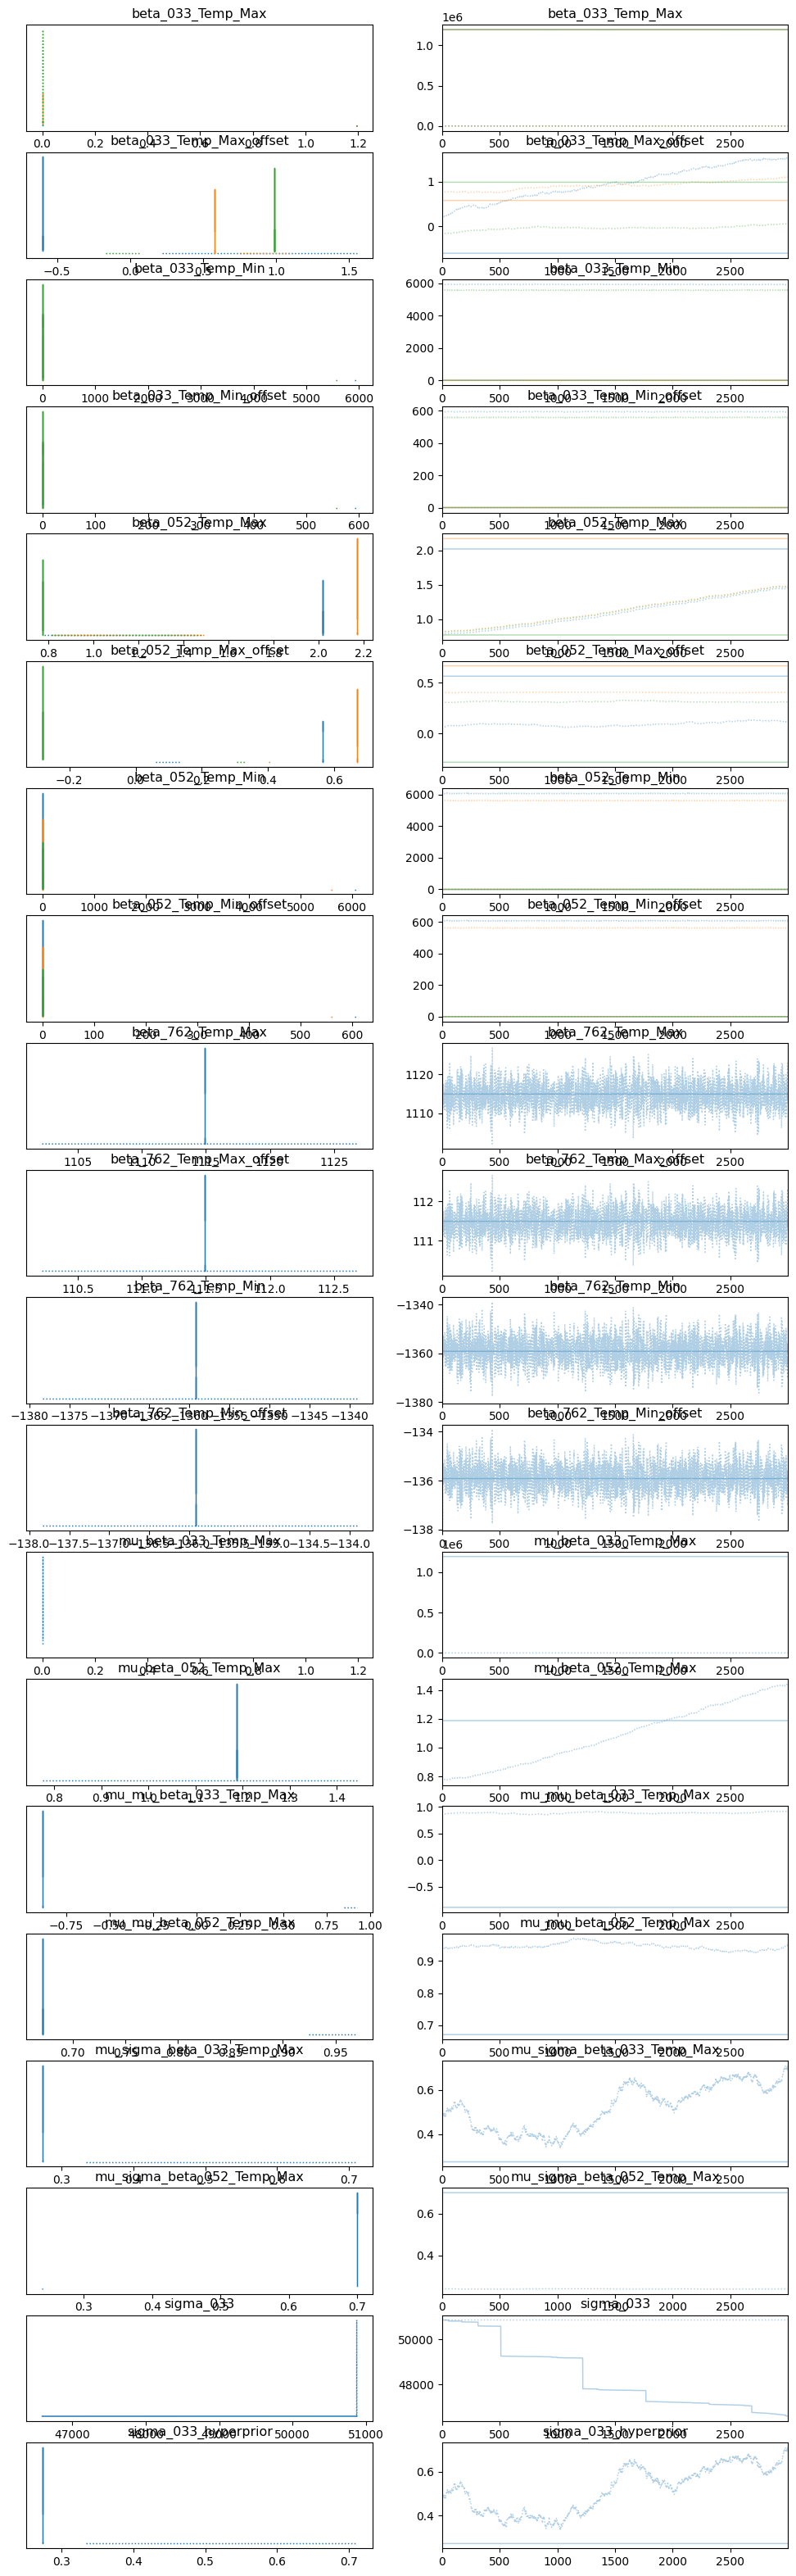

In [24]:
pm.plot_trace(trace)

# **2: Cálculo del "noise" (residuos) y Predicciones**

# **calulos para N1_033:**

In [25]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_033:", beta_temp_max_N1_033)
print("beta_temp_min_N1_033:", beta_temp_min_N1_033)

beta_temp_max_N1_033: 597737.908217383
beta_temp_min_N1_033: 1922.2477054047174


In [26]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_033 = np.array(Reparto_N1_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_N1_033 = Reparto_N1_033 - (beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise N1_033:", noise_N1_033[:10])

Noise N1_033: [1504598.3228392  -585925.46853969 2182377.84493862 6606510.15508259
 5366982.06349803 4652727.12208368 2373127.39085786 1953656.42452596
 1731991.49465249 1232370.41996514]


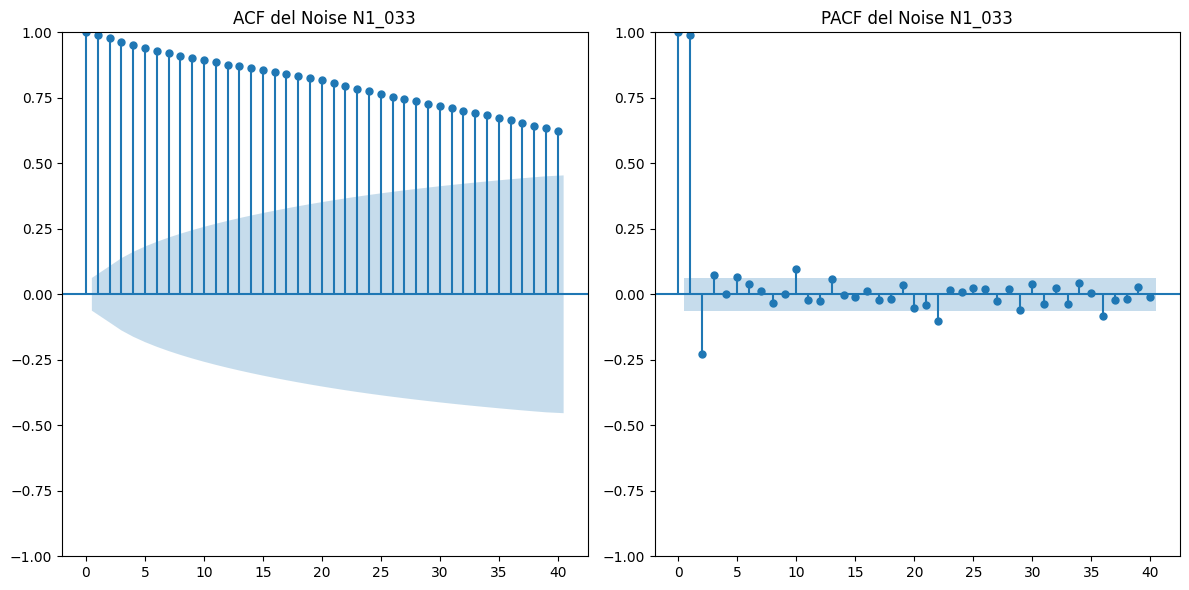

In [27]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise N1_033')

plt.tight_layout()
plt.show()

In [28]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_033_fit = model_auto_arima.fit(noise_N1_033)

# Realizar predicciones
predicciones_arima_N1_033 = model_N1_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32949.666, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33010.043, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32957.225, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32950.368, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33008.045, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32948.195, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32951.740, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32951.706, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32949.953, Time=0.54 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32953.760, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32948.689, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=32949.481, Time=1.78 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32946.160, Time=2.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32949.741, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0

In [117]:
# Aplicar ARIMA sobre el noise de N1_033
model_N1_033_arima = ARIMA(noise_N1_033, order=(1,1,2))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_N1_033_fit = model_N1_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_033 = model_N1_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_033)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-4247039.25152346 -4337315.85697585 -4410046.46228234 -4468641.27676103
 -4515847.70752459 -4553879.18053565 -4584518.92423149 -4609203.58194837
 -4629090.57358409 -4645112.36496784]


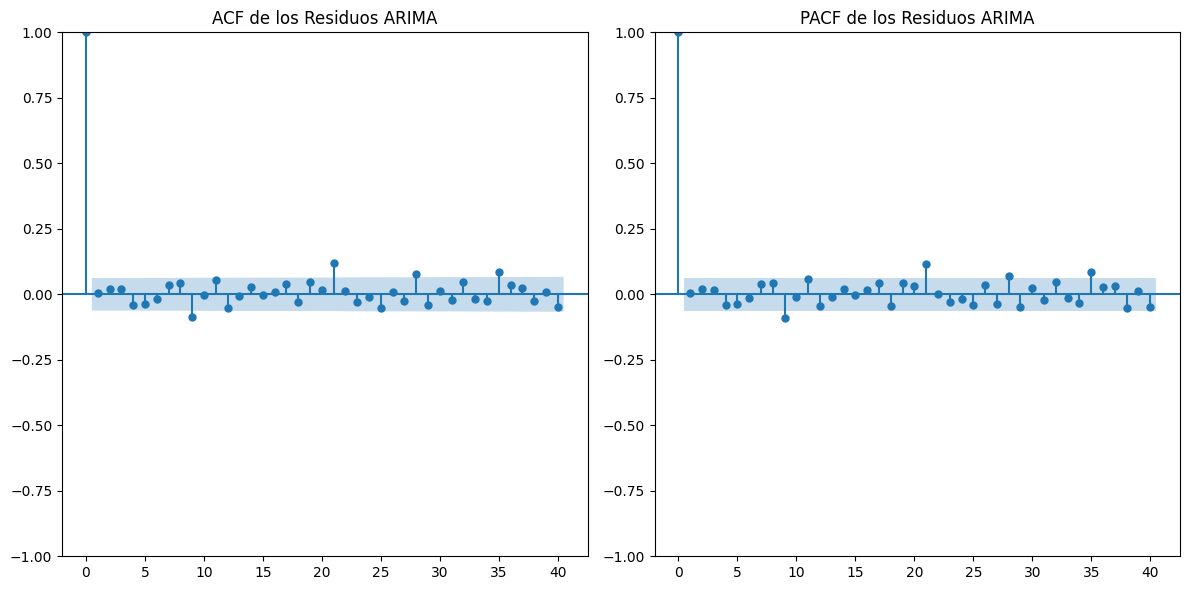

In [118]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [119]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [120]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_033)


[17966737.70521877 19160291.27394814 18566397.86114156 17372844.2924122
 16777028.63190022 17968659.95292418 17368999.79700139 18562553.36573076
 19164135.76935894 17966737.70521877]


In [121]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

In [122]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_033['Acumulado'] = df_predicciones_N1_033['Prediccion'].cumsum()

In [123]:
df_predicciones_N1_033.to_excel('/content/drive/MyDrive/GNS_N1.xlsx', index=False)
df_predicciones_N1_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.371970e+07,30,18,1.371970e+07
1,2024-06-02,1.482298e+07,32,17,2.854267e+07
2,2024-06-03,1.415635e+07,31,19,4.269903e+07
3,2024-06-04,1.290420e+07,29,20,5.560323e+07
4,2024-06-05,1.226118e+07,28,21,6.786441e+07


# **calulos para M3_033:**


In [36]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M3_033)
print("beta_temp_min_M3_033:", beta_temp_min_M3_033)

beta_temp_max_M3_033: 597737.908217383
beta_temp_min_M3_033: 1922.2477054047174


In [37]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_033 = np.array(Reparto_M3_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M3_033 = Reparto_M3_033 - (beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M3_033:", noise_M3_033[:10])

Noise M3_033: [ -773099.6771608  -1642544.46853969   759240.84493862  4622526.15508259
  3260673.06349803  2800469.12208368  1239758.39085786   915973.42452596
  1183427.49465249   804265.41996514]


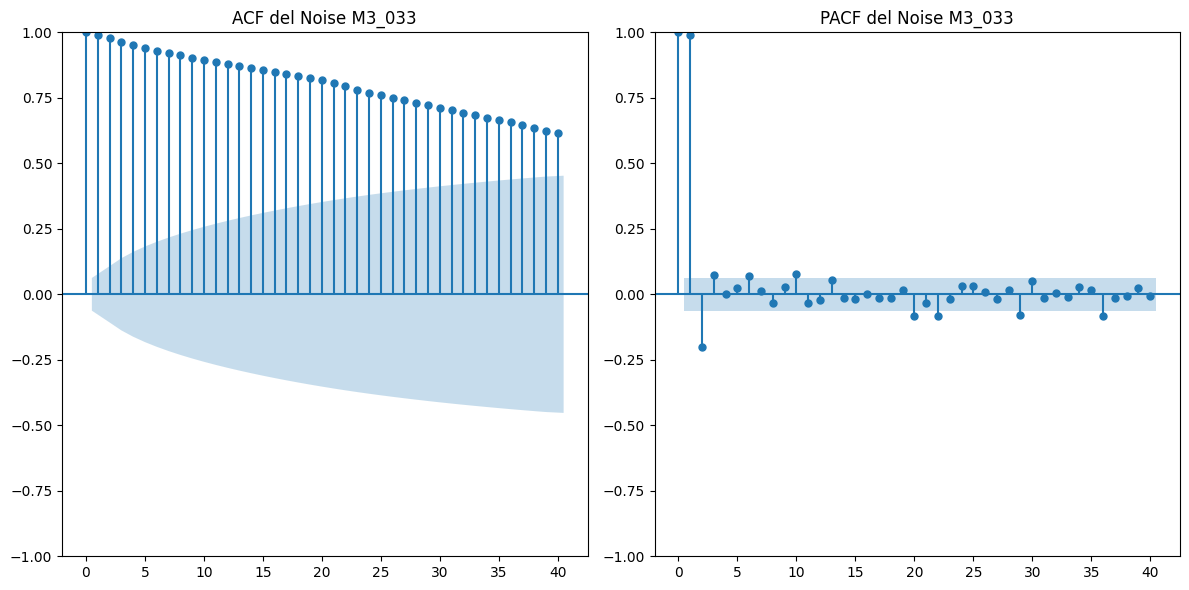

In [38]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M3_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M3_033')

plt.tight_layout()
plt.show()

In [39]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M3_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M3_033_fit = model_auto_arima.fit(noise_M3_033)

# Realizar predicciones
predicciones_arima_M3_033 = model_M3_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33006.906, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33055.411, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33013.217, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33007.332, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33053.419, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33005.356, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=33008.601, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33008.736, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33007.025, Time=0.57 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=33009.470, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33006.117, Time=1.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=33009.015, Time=2.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=33003.197, Time=1.83 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=33006.606, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0

In [40]:
# Aplicar ARIMA sobre el noise de N1_033
model_M3_033_arima = ARIMA(noise_M3_033, order=(1,1,2))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M3_033_fit = model_M3_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_033 = model_M3_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_033)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-13551809.08828473 -13628053.50761694 -13688434.80971187
 -13736253.41302227 -13774123.06377876 -13804113.70234071
 -13827864.60532992 -13846673.98785234 -13861569.96342999
 -13873366.74028567]


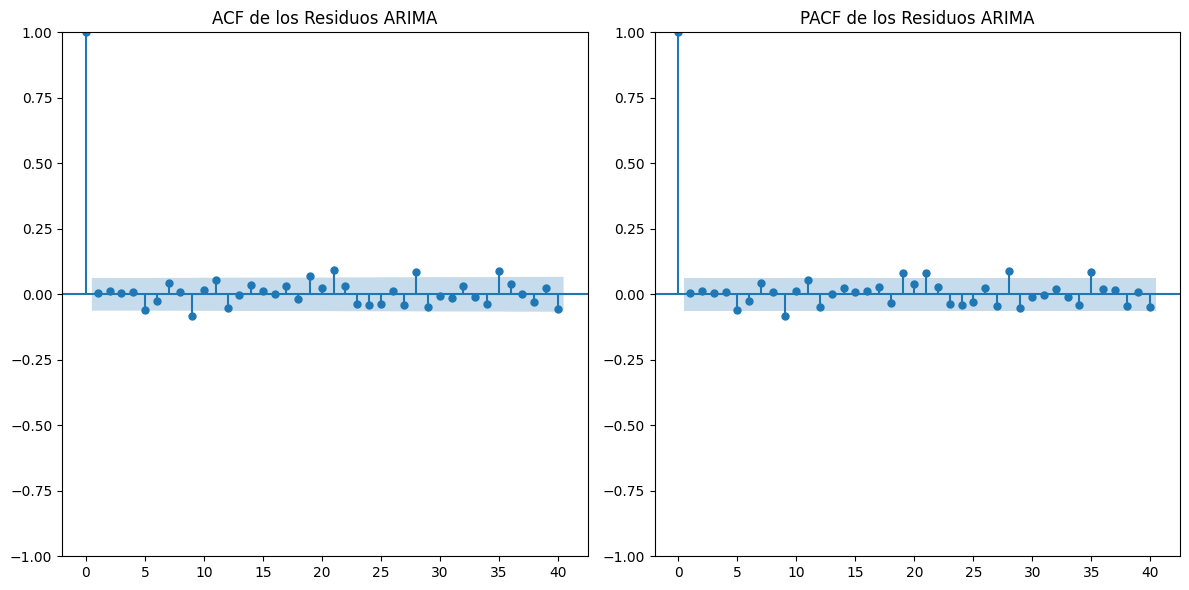

In [41]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M3_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [42]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [43]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_033)

[17966737.70521877 19160291.27394814 18566397.86114156 17372844.2924122
 16777028.63190022 17968659.95292418 17368999.79700139 18562553.36573076
 19164135.76935894 17966737.70521877]


In [44]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

In [45]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_033['Acumulado'] = df_predicciones_M3_033['Prediccion'].cumsum()

In [46]:
df_predicciones_M3_033.to_excel('/content/drive/MyDrive/GNS_M3.xlsx', index=False)
df_predicciones_M3_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,4.414929e+06,30,18,4.414929e+06
1,2024-06-02,5.532238e+06,32,17,9.947166e+06
2,2024-06-03,4.877963e+06,31,19,1.482513e+07
3,2024-06-04,3.636591e+06,29,20,1.846172e+07
4,2024-06-05,3.002906e+06,28,21,2.146463e+07


# **calulos para M15_033:**

In [47]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M15_033)
print("beta_temp_min_M15_033:", beta_temp_min_M15_033)

beta_temp_max_M3_033: 597737.908217383
beta_temp_min_M15_033: 1922.2477054047174


In [48]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_033 = np.array(Reparto_M15_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M15_033 = Reparto_M15_033 - (beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M15_033:", noise_M15_033[:10])

Noise M15_033: [ -773099.6771608  -1642544.46853969   759240.84493862  4622526.15508259
  3260673.06349803  2800469.12208368  1239758.39085786   915973.42452596
  1183427.49465249   804265.41996514]


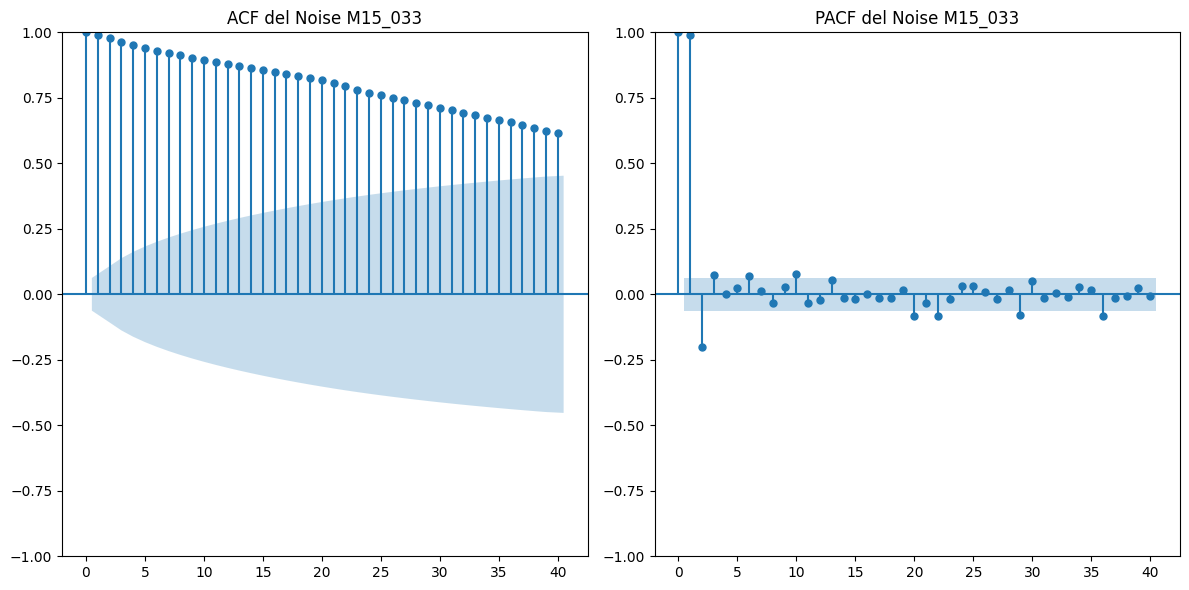

In [49]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M15_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M15_033')

plt.tight_layout()
plt.show()

In [50]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M15_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M15_033_fit = model_auto_arima.fit(noise_M15_033)

# Realizar predicciones
predicciones_arima_M15_033 = model_M15_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33006.906, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33055.411, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33013.217, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33007.332, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33053.419, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33005.356, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=33008.601, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33008.736, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33007.025, Time=2.64 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=33009.470, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33006.117, Time=3.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=33009.015, Time=2.45 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=33003.197, Time=2.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=33006.606, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0

In [51]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_033_arima = ARIMA(noise_M15_033, order=(1,1,2))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_033_fit = model_M15_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_033 = model_M15_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_033)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-13551809.08828473 -13628053.50761694 -13688434.80971187
 -13736253.41302227 -13774123.06377876 -13804113.70234071
 -13827864.60532992 -13846673.98785234 -13861569.96342999
 -13873366.74028567]


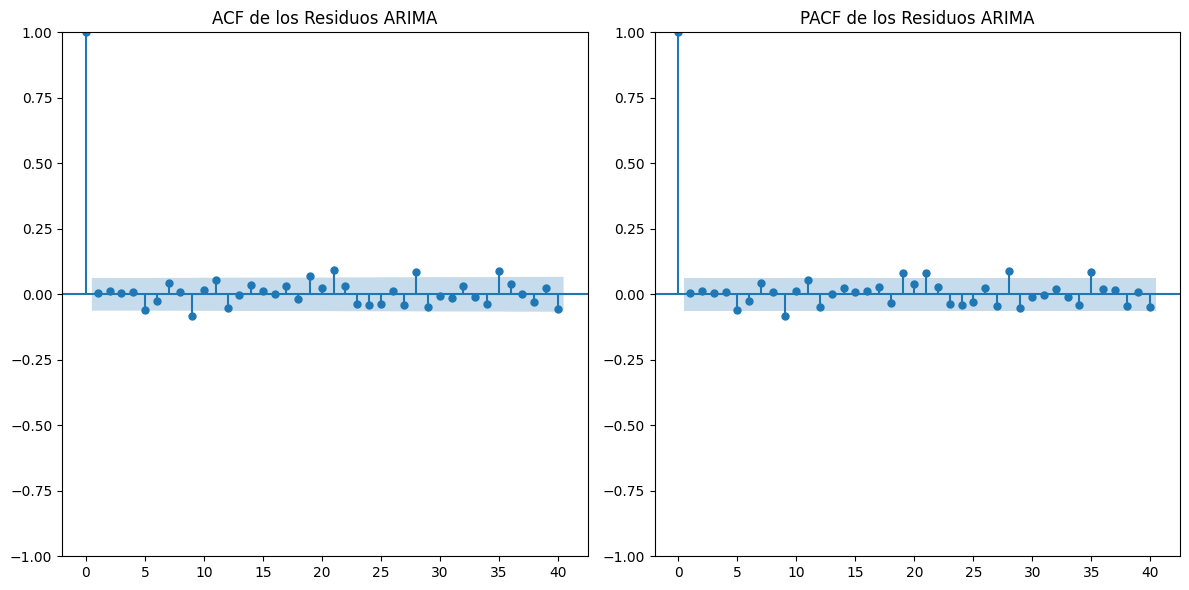

In [52]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M15_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [53]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [54]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_033)

[17966737.70521877 19160291.27394814 18566397.86114156 17372844.2924122
 16777028.63190022 17968659.95292418 17368999.79700139 18562553.36573076
 19164135.76935894 17966737.70521877]


In [55]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

In [56]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_033['Acumulado'] = df_predicciones_M15_033['Prediccion'].cumsum()

In [57]:
df_predicciones_M15_033.to_excel('/content/drive/MyDrive/GNS_M15.xlsx', index=False)
df_predicciones_M15_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,4.414929e+06,30,18,4.414929e+06
1,2024-06-02,5.532238e+06,32,17,9.947166e+06
2,2024-06-03,4.877963e+06,31,19,1.482513e+07
3,2024-06-04,3.636591e+06,29,20,1.846172e+07
4,2024-06-05,3.002906e+06,28,21,2.146463e+07


# **calulos para N1_052:**

In [58]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_052:", beta_temp_max_N1_052)
print("beta_temp_min_N1_052:", beta_temp_min_N1_052)

beta_temp_max_N1_052: 1.385234759830097
beta_temp_min_N1_052: 1946.4368847832957


In [59]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_052 = np.array(Reparto_N1_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_N1_052 = Reparto_N1_052 - (beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise N1_052:", noise_N1_052[:10])

Noise N1_052: [5726179.16730221 4724858.33553095 5292790.15271572 6002050.90331761
 6483325.35772309 5934349.57504874 5352581.50640101 5208336.69058921
 4802308.30374532 4649410.83148075]


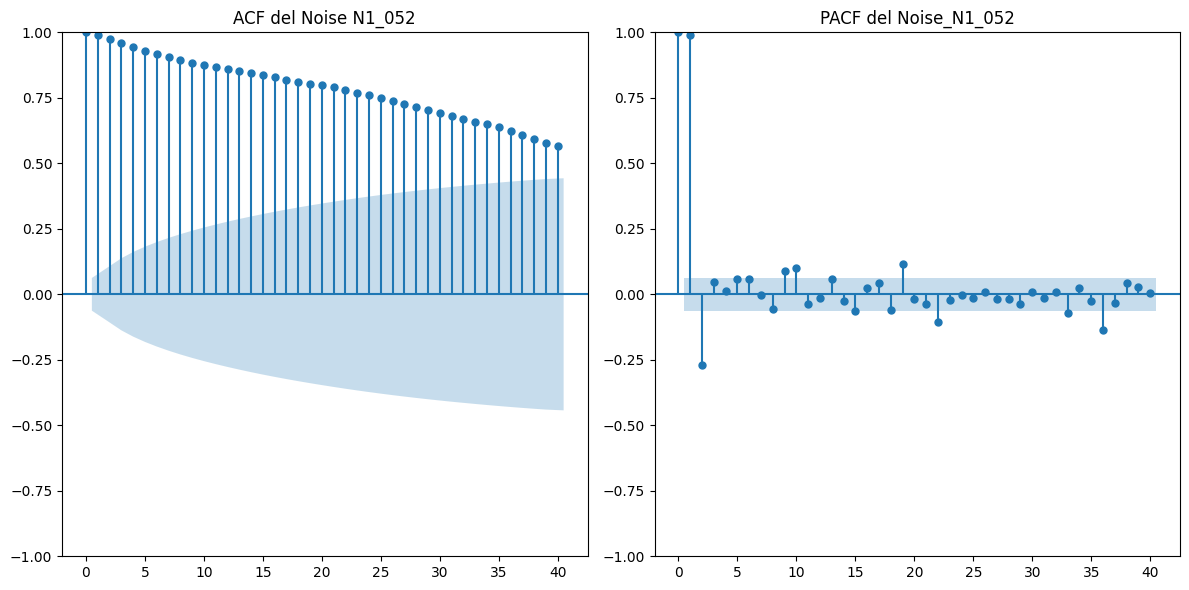

In [60]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_052')

plt.tight_layout()
plt.show()

In [61]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_052_fit = model_auto_arima.fit(noise_N1_052)

# Realizar predicciones
predicciones_arima_N1_052 = model_N1_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31530.288, Time=7.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31612.587, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31536.635, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31534.138, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31610.589, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31537.373, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31528.309, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31535.406, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31535.074, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31530.297, Time=1.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31536.692, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31530.619, Time=1.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31526.296, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31533.406, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0

In [62]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_052_arima = ARIMA(noise_N1_052, order=(2,1,1))
model_N1_052_fit = model_N1_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_052 = model_N1_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_052)

[8800421.41719162 8760889.14629592 8738165.44983088 8724234.69491277
 8715258.17409783 8709268.59710892 8705180.0515552  8702349.37126241
 8700372.73875686 8698985.46304832]


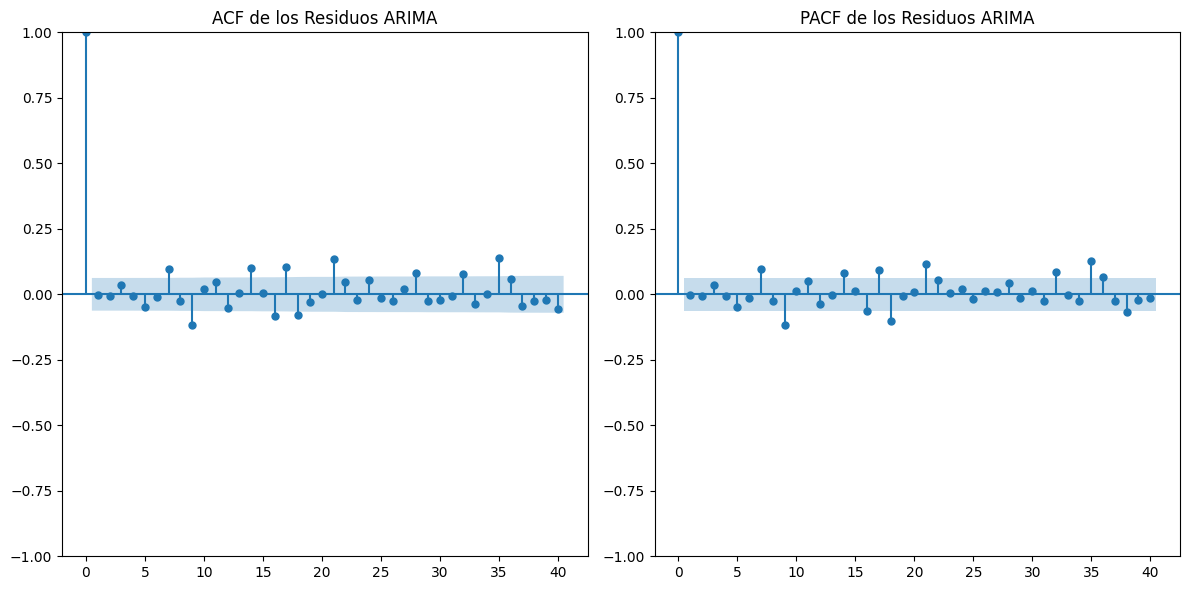

In [63]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [64]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [65]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_052)

[35077.42096889 33133.75455363 37025.24308844 38968.9095037
 40913.96115372 37023.85785368 35076.03573413 33132.36931887
 37026.6283232  35077.42096889]


In [66]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

In [67]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_052['Acumulado'] = df_predicciones_N1_052['Prediccion'].cumsum()

In [68]:
df_predicciones_N1_052.to_excel('/content/drive/MyDrive/SUR_N1.xlsx', index=False)
df_predicciones_N1_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,8.835499e+06,30,18,8.835499e+06
1,2024-06-02,8.794023e+06,32,17,1.762952e+07
2,2024-06-03,8.775191e+06,31,19,2.640471e+07
3,2024-06-04,8.763204e+06,29,20,3.516792e+07
4,2024-06-05,8.756172e+06,28,21,4.392409e+07


# **calulos para M3_052:**


In [69]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_052:", beta_temp_max_M3_052)
print("beta_temp_min_M3_052:", beta_temp_min_M3_052)

beta_temp_max_M3_052: 1.385234759830097
beta_temp_min_M3_052: 1946.4368847832957


In [70]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_052 = np.array(Reparto_M3_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_M3_052 = Reparto_M3_052 - (beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M3_052:", noise_M3_052[:10])

Noise M3_052: [4936185.16730221 4562717.33553095 4966224.15271572 5523997.90331761
 6025186.35772309 5571449.57504874 5294135.50640101 5189751.69058921
 4973414.30374532 4816196.83148075]


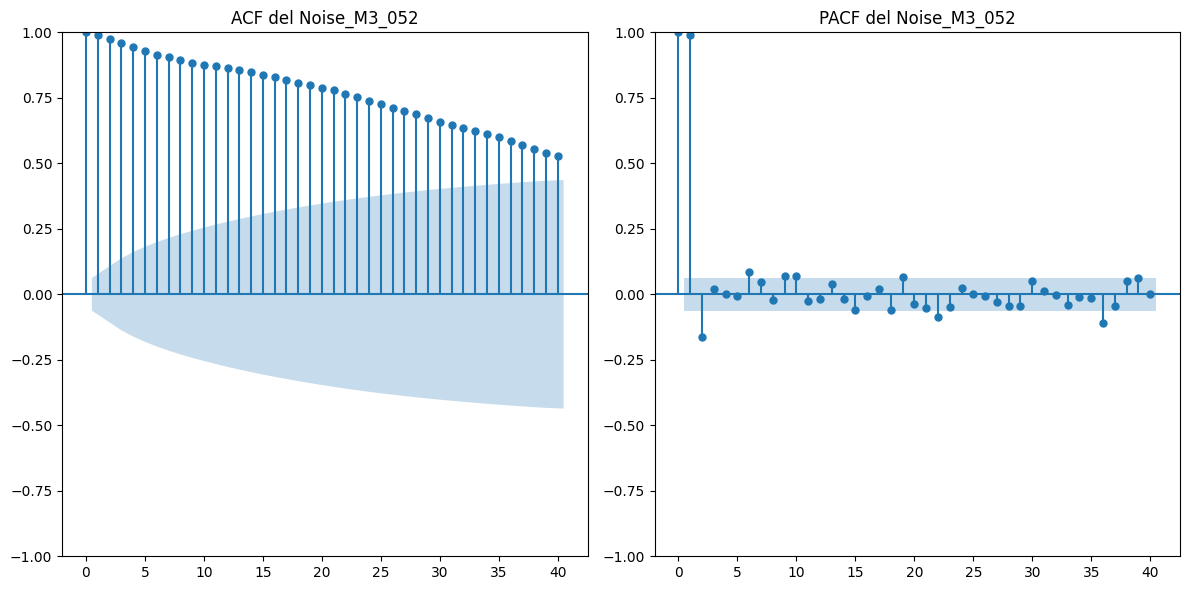

In [71]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M3_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M3_052')

plt.tight_layout()
plt.show()

In [72]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M3_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M3_052_fit = model_auto_arima.fit(noise_M3_052)

# Realizar predicciones
predicciones_arima_M3_052 = model_M3_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31895.727, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36510.233, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35796.848, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31896.823, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31896.825, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31895.131, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31899.039, Time=0.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=31900.537, Time=0.68 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=31898.249, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31896.417, Time=0.64 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=31900.526, Time=0.33 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=31891.514, Time=2.18 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=31885.923, Time=6.94 sec
 ARIMA(5,0,2)(0,0,0)[0]  

In [73]:
# Aplicar ARIMA sobre el noise de M3_052
model_M3_052_arima = ARIMA(noise_M3_052, order=(5,0,2))
model_M3_052_fit = model_M3_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_052 = model_M3_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_052)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[ 109700.61674102  288653.49377282  632505.99390153  920471.15662757
 1082134.52839159 1349115.21558201 1685967.9373304  1882182.4780632
 2063446.38016368 2379853.86879781]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


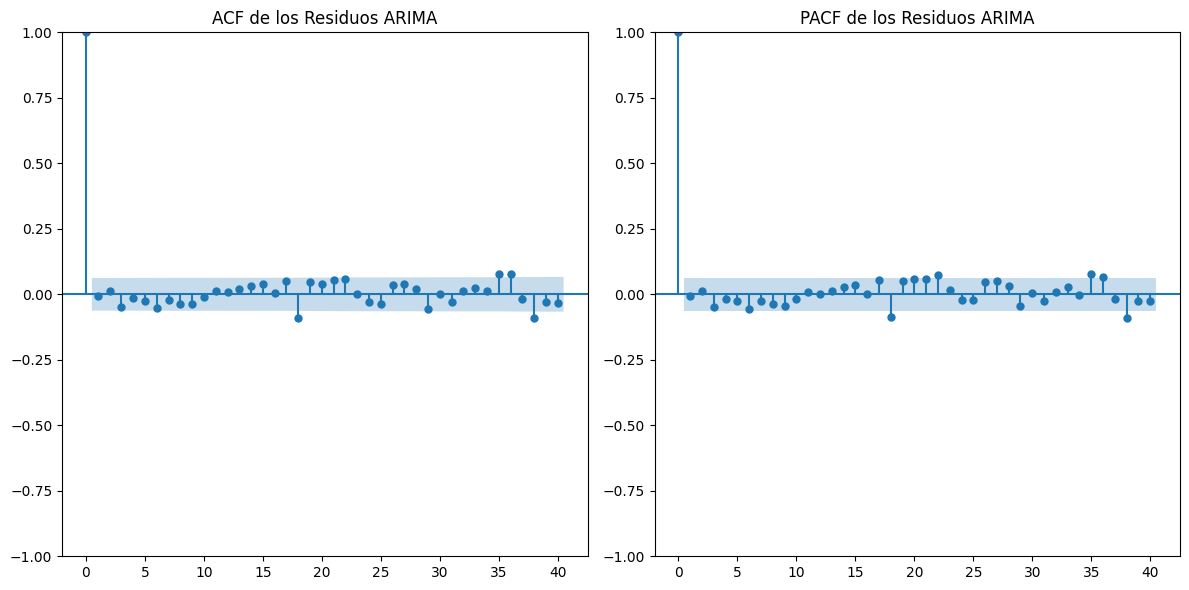

In [74]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M3_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [75]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [76]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_052)

[35077.42096889 33133.75455363 37025.24308844 38968.9095037
 40913.96115372 37023.85785368 35076.03573413 33132.36931887
 37026.6283232  35077.42096889]


In [77]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

In [78]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_052['Acumulado'] = df_predicciones_M3_052['Prediccion'].cumsum()

In [79]:
df_predicciones_M3_052.to_excel('/content/drive/MyDrive/SUR_M3.xlsx', index=False)
df_predicciones_M3_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,1.447780e+05,30,18,1.447780e+05
1,2024-06-02,3.217872e+05,32,17,4.665653e+05
2,2024-06-03,6.695312e+05,31,19,1.136097e+06
3,2024-06-04,9.594401e+05,29,20,2.095537e+06
4,2024-06-05,1.123048e+06,28,21,3.218585e+06


# **calulos para M15_052:**

In [80]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M15_052:", beta_temp_max_M15_052)
print("beta_temp_min_M15_052:", beta_temp_min_M15_052)

beta_temp_max_M15_052: 1.385234759830097
beta_temp_min_M15_052: 1946.4368847832957


In [81]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_052 = np.array(Reparto_M15_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_033
noise_M15_052 = Reparto_M15_052 - (beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M15_052:", noise_M15_052[:10])

Noise M15_052: [4936185.16730221 4562717.33553095 4966224.15271572 5523997.90331761
 6025186.35772309 5571449.57504874 5294135.50640101 5189751.69058921
 4973414.30374532 4816196.83148075]


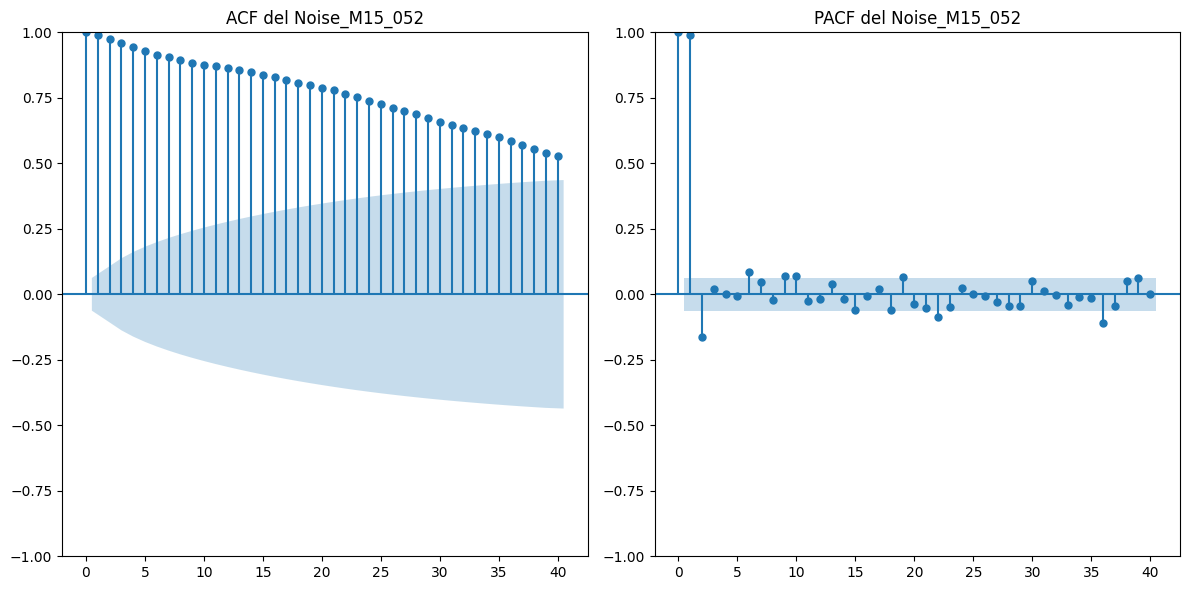

In [82]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M15_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M15_052')

plt.tight_layout()
plt.show()

In [83]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M15_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M15_052_fit = model_auto_arima.fit(noise_M15_052)

# Realizar predicciones
predicciones_arima_M15_052 = model_M15_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31895.727, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36510.233, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35796.848, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31896.823, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31896.825, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31895.131, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31899.039, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=31900.537, Time=0.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=31898.249, Time=3.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31896.417, Time=2.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=31900.526, Time=0.95 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=31891.514, Time=2.16 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=31885.923, Time=2.79 sec
 ARIMA(5,0,2)(0,0,0)[0]  

In [84]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_052_arima = ARIMA(noise_M15_052, order=(5,0,5))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_052_fit = model_M15_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_052 = model_M15_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_052)

[  38140.97906499  139997.15315054  442354.22015436  660099.12052048
  713649.02021774  908578.58475908 1181568.482088   1254960.21797016
 1313619.41931117 1553194.75849757]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


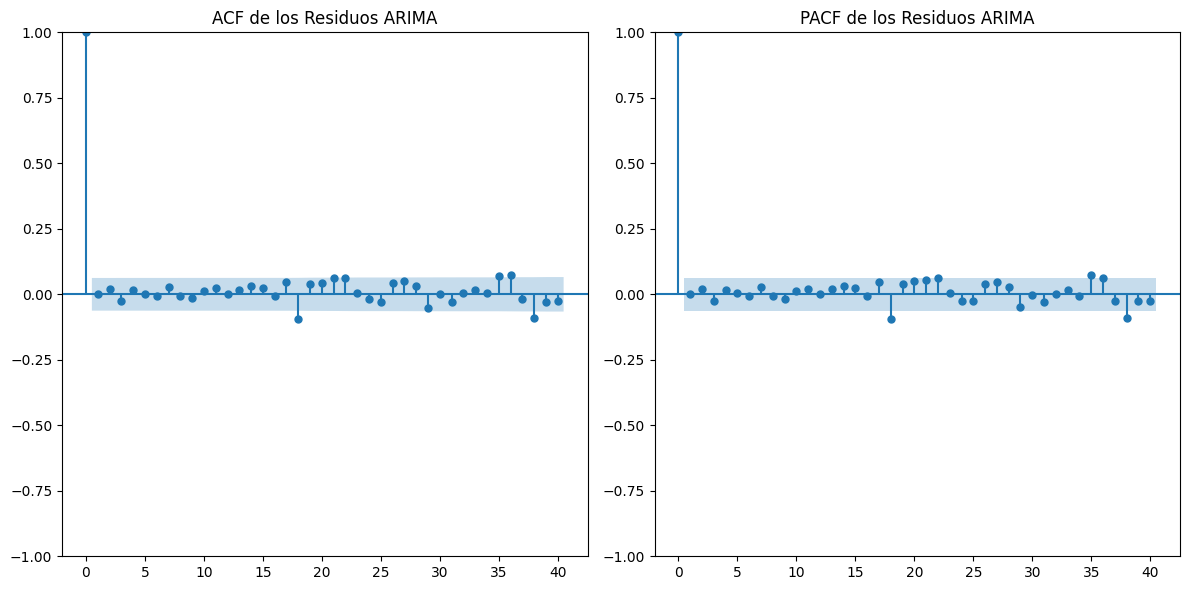

In [85]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M15_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [86]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [87]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_052)

[35077.42096889 33133.75455363 37025.24308844 38968.9095037
 40913.96115372 37023.85785368 35076.03573413 33132.36931887
 37026.6283232  35077.42096889]


In [88]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

In [89]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_052['Acumulado'] = df_predicciones_M15_052['Prediccion'].cumsum()

In [90]:
df_predicciones_M15_052.to_excel('/content/drive/MyDrive/SUR_M15.xlsx', index=False)
df_predicciones_M15_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,73218.400034,30,18,7.321840e+04
1,2024-06-02,173130.907704,32,17,2.463493e+05
2,2024-06-03,479379.463243,31,19,7.257288e+05
3,2024-06-04,699068.030024,29,20,1.424797e+06
4,2024-06-05,754562.981371,28,21,2.179360e+06


# **calulos para N1_762:**

In [91]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_762:", beta_temp_max_N1_762)
print("beta_temp_min_N1_762:", beta_temp_min_N1_762)

beta_temp_max_N1_762: 1114.8292002352362
beta_temp_min_N1_762: -1359.0097110918248


In [92]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_762 = np.array(Reparto_N1_762)
Temp_ponderada_Max_762 = np.array(Temp_ponderada_Max_762)
Temp_ponderada_Min_762 = np.array(Temp_ponderada_Min_762)

# Calcular el noise para N1_052
noise_N1_762 = Reparto_N1_762 - (beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762)

# Verificar el resultado del noise
print("Noise N1_762:", noise_N1_762[:10])

Noise N1_762: [ -4800.80701544  -7800.69813204  -6728.08046028  -5815.56626944
 -10581.28977363 -11424.00684822 -10665.14304266  -5800.92332151
  -5475.98017099 -11300.84763962]


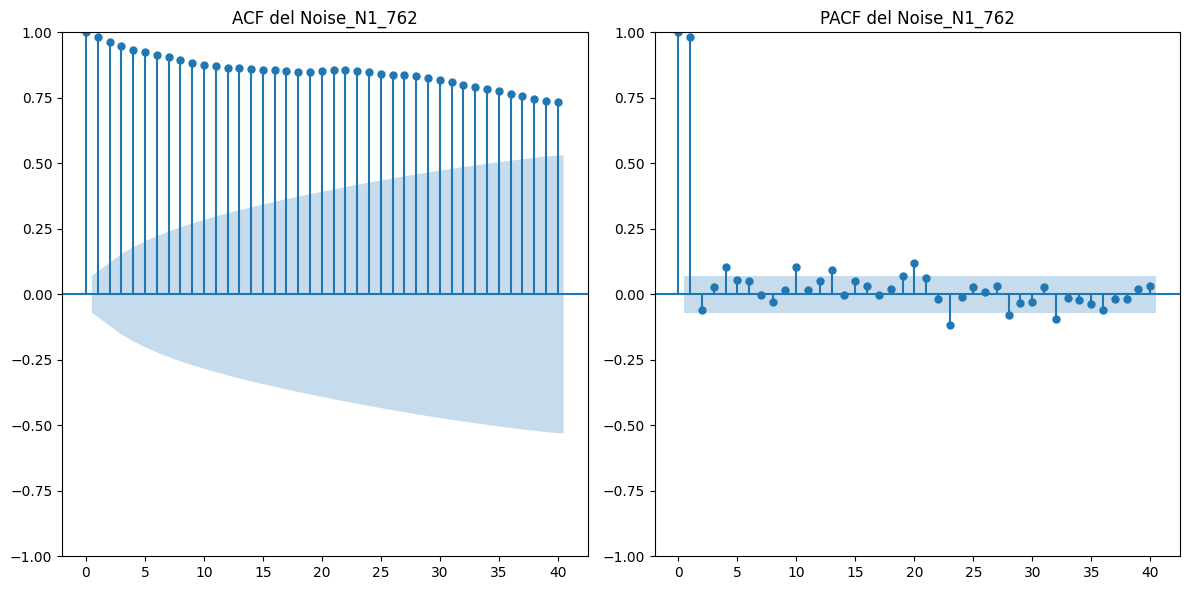

In [93]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('ACF del Noise_N1_762')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_762')

plt.tight_layout()
plt.show()

In [94]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_762, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_762_fit = model_auto_arima.fit(noise_N1_762)

# Realizar predicciones
predicciones_arima_N1_762 = model_N1_762_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14564.772, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14585.956, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14585.991, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14585.823, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14584.045, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14564.374, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14586.828, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14572.085, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14563.640, Time=1.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14578.624, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14565.884, Time=1.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14565.433, Time=1.40 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=14576.591, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=14574.015, Time=2.19 sec
 ARIMA(1,1,3)(0,0,0

In [95]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_762_arima = ARIMA(noise_N1_762, order=(1,1,3))# Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_N1_762_fit = model_N1_762_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_762 = model_N1_762_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_762)

[16867.90906374 16809.58374332 16717.05940483 16645.99763293
 16591.41982663 16549.50225461 16517.30816396 16492.58203067
 16473.59153723 16459.00620611]


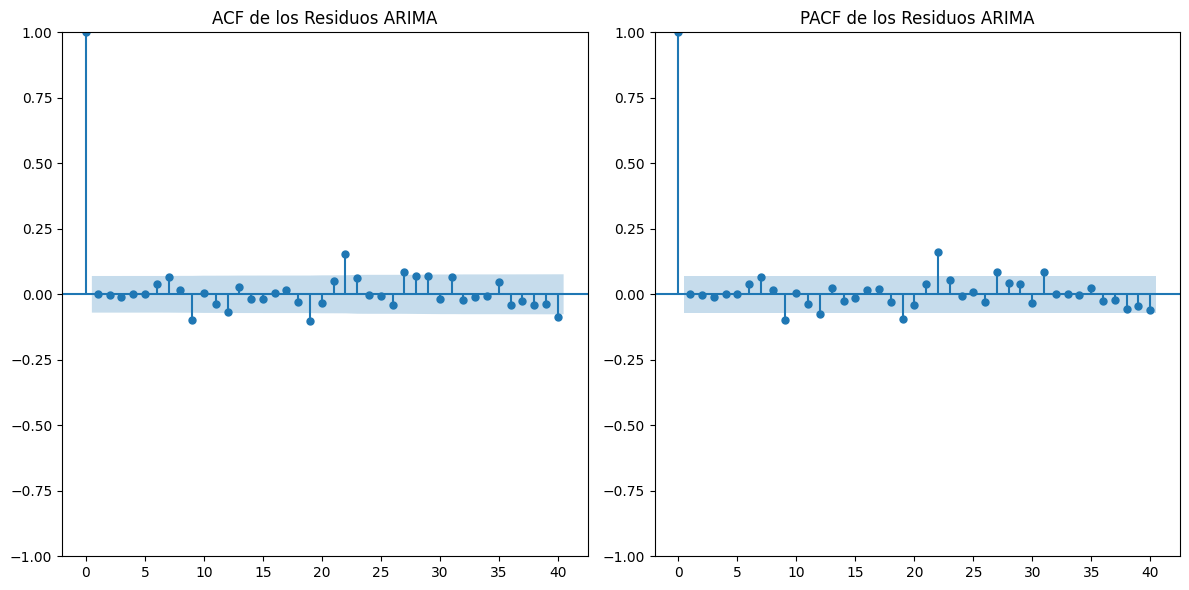

In [96]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_762_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

In [97]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 762
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

In [98]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_762 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_762)

[ 8982.7012074  12571.36931897  8738.52069655  5149.85258499
  2676.01367366  7623.69149631  7867.87200717 11456.54011873
  9853.34989678  8982.7012074 ]


In [99]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

In [100]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_762 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_762,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_762['Acumulado'] = df_predicciones_N1_762['Prediccion'].cumsum()

In [101]:
df_predicciones_N1_762.to_excel('/content/drive/MyDrive/NC_N1.xlsx', index=False)
df_predicciones_N1_762.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,25850.610271,30,18,25850.610271
1,2024-06-02,29380.953062,32,17,55231.563333
2,2024-06-03,25455.580101,31,19,80687.143435
3,2024-06-04,21795.850218,29,20,102482.993653
4,2024-06-05,19267.433500,28,21,121750.427153


#**3-Backtesting:**

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE N1_033: 2820997.9723737543
RMSE N1_033: 4427298.270007376


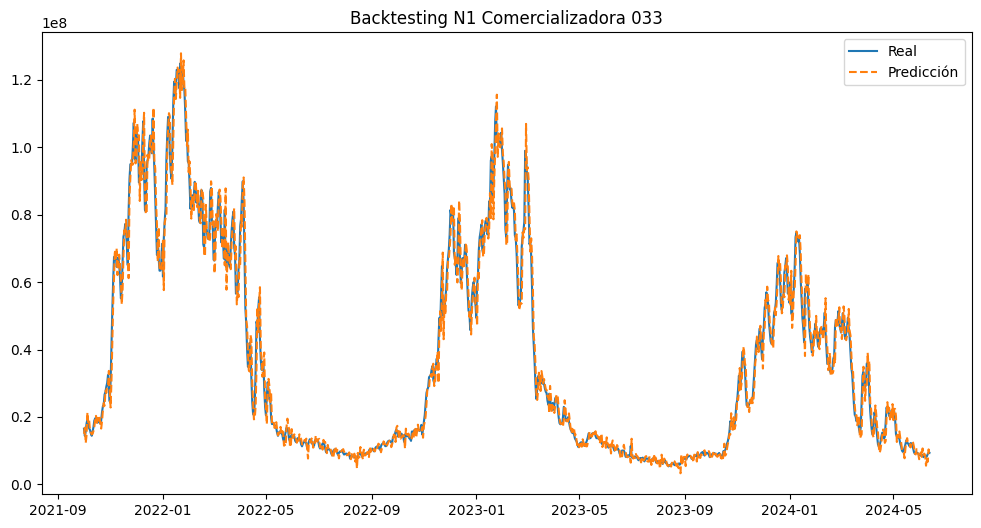

In [125]:
# Datos reales: Reparto_N1_033
reales_N1_033 = np.array(Reparto_N1_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_033 = reales_N1_033 - predicciones_bayes_N1_033

# Ajustar modelo ARIMA para el residual (noise)
model_N1_033_arima = ARIMA(noise_N1_033, order=(1,1,1))
model_N1_033_fit = model_N1_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_033 = model_N1_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

# Calcular métricas de evaluación para el backtesting
mae_N1_033 = mean_absolute_error(reales_N1_033, predicciones_finales_N1_033)
rmse_N1_033 = np.sqrt(mean_squared_error(reales_N1_033, predicciones_finales_N1_033))

print(f"MAE N1_033: {mae_N1_033}")
print(f"RMSE N1_033: {rmse_N1_033}")

# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Real'], label='Real')
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 033')
plt.legend()
plt.show()

In [126]:
# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})
df_backtesting_N1_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,16511360.0,1.500676e+07
1,2021-10-02,14379033.0,1.681920e+07
2,2021-10-03,15656470.0,1.223858e+07
3,2021-10-04,18127248.0,1.463763e+07
4,2021-10-05,19279748.0,2.131056e+07


MAE M3_033: 2803991.5401497646
RMSE M3_033: 4557150.878168868


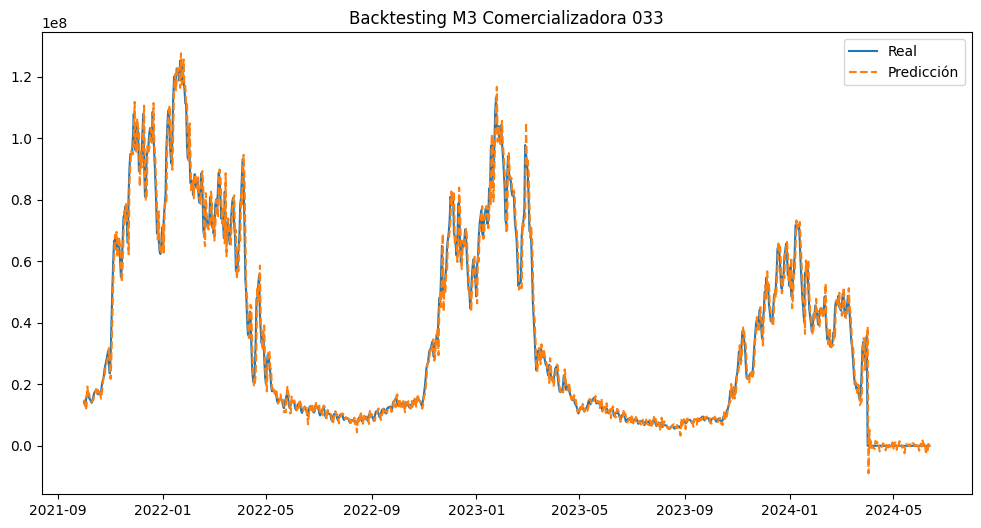

In [127]:
# Datos reales: Reparto_M3_033
reales_M3_033 = np.array(Reparto_M3_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_033 = reales_M3_033 - predicciones_bayes_M3_033

# Ajustar modelo ARIMA para el residual (noise)
model_M3_033_arima = ARIMA(noise_M3_033, order=(1,1,1))
model_M3_033_fit = model_M3_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_033 = model_M3_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

# Calcular métricas de evaluación para el backtesting
mae_M3_033 = mean_absolute_error(reales_M3_033, predicciones_finales_M3_033)
rmse_M3_033 = np.sqrt(mean_squared_error(reales_M3_033, predicciones_finales_M3_033))

print(f"MAE M3_033: {mae_M3_033}")
print(f"RMSE M3_033: {rmse_M3_033}")

# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Real'], label='Real')
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 033')
plt.legend()
plt.show()

In [128]:
# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})
df_backtesting_M3_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,1.500676e+07
1,2021-10-02,13322414.0,1.402742e+07
2,2021-10-03,14233333.0,1.168655e+07
3,2021-10-04,16143264.0,1.287560e+07
4,2021-10-05,17173439.0,1.922802e+07


MAE M15_033: 2803991.5401497646
RMSE M15_033: 4557150.878168868


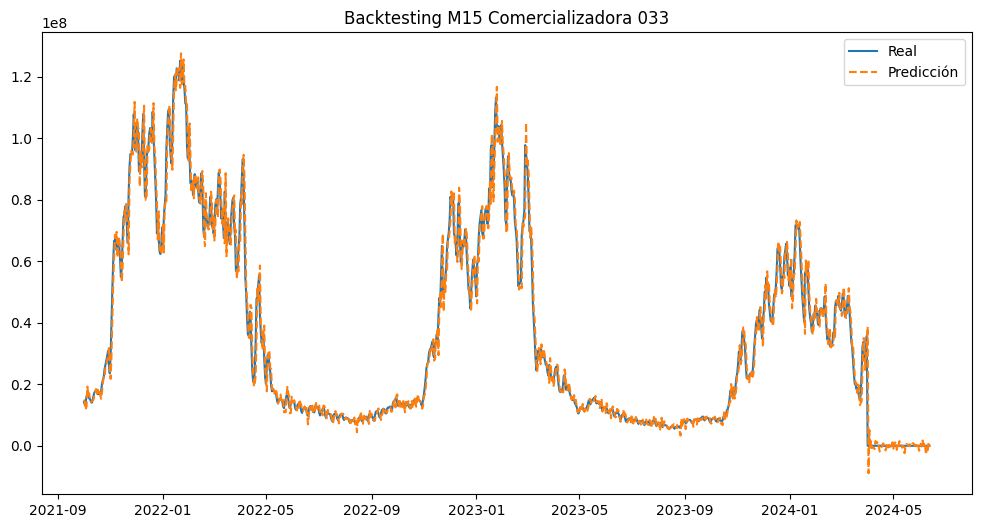

In [129]:
# Datos reales: Reparto_M15_033
reales_M15_033 = np.array(Reparto_M15_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_033 = reales_M15_033 - predicciones_bayes_M15_033

# Ajustar modelo ARIMA para el residual (noise)
model_M15_033_arima = ARIMA(noise_M15_033, order=(1,1,1))
model_M15_033_fit = model_M15_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_033 = model_M15_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

# Calcular métricas de evaluación para el backtesting
mae_M15_033 = mean_absolute_error(reales_M15_033, predicciones_finales_M15_033)
rmse_M15_033 = np.sqrt(mean_squared_error(reales_M15_033, predicciones_finales_M15_033))

print(f"MAE M15_033: {mae_M15_033}")
print(f"RMSE M15_033: {rmse_M15_033}")

# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Real'], label='Real')
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 033')
plt.legend()
plt.show()


In [130]:
# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})
df_backtesting_M15_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,1.500676e+07
1,2021-10-02,13322414.0,1.402742e+07
2,2021-10-03,14233333.0,1.168655e+07
3,2021-10-04,16143264.0,1.287560e+07
4,2021-10-05,17173439.0,1.922802e+07


MAE N1_052: 1324043.7974485906
RMSE N1_052: 2164874.53309519


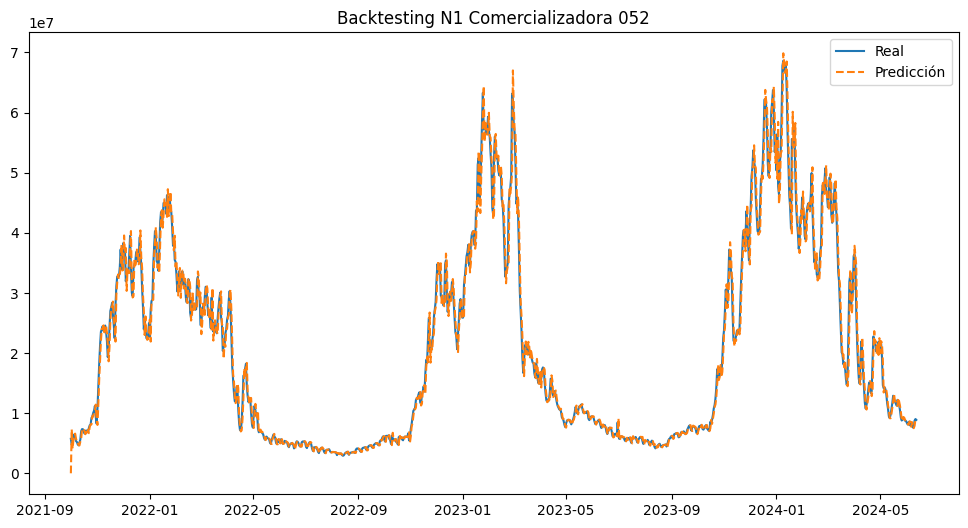

In [131]:
# Datos reales: Reparto_N1_052
reales_N1_052 = np.array(Reparto_N1_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_052 = reales_N1_052 - predicciones_bayes_N1_052

# Ajustar modelo ARIMA para el residual (noise)
model_N1_052_arima = ARIMA(noise_N1_052, order=(1,1,1))
model_N1_052_fit = model_N1_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_052 = model_N1_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

# Calcular métricas de evaluación para el backtesting
mae_N1_052 = mean_absolute_error(reales_N1_052, predicciones_finales_N1_052)
rmse_N1_052 = np.sqrt(mean_squared_error(reales_N1_052, predicciones_finales_N1_052))

print(f"MAE N1_052: {mae_N1_052}")
print(f"RMSE N1_052: {rmse_N1_052}")

# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Real'], label='Real')
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 052')
plt.legend()
plt.show()


In [132]:
# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})
df_backtesting_N1_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,5754009.0,2.782983e+04
1,2021-10-02,4752727.0,7.332048e+06
2,2021-10-03,5318125.0,4.150630e+06
3,2021-10-04,6022593.0,5.596254e+06
4,2021-10-05,6504963.0,6.174580e+06


MAE M3_052: 1348612.4517984833
RMSE M3_052: 2553790.0899740453


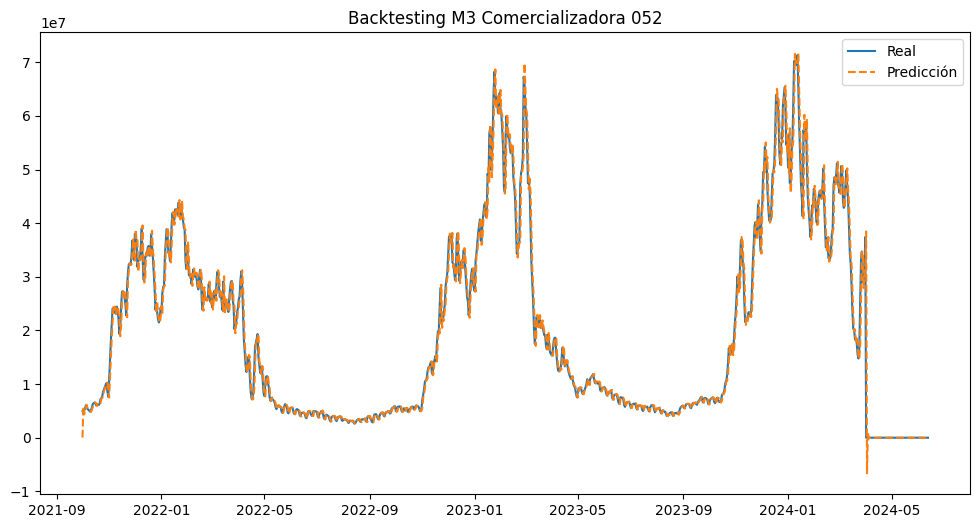

In [133]:
# Datos reales: Reparto_M3_052
reales_M3_052 = np.array(Reparto_M3_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_052 = reales_M3_052 - predicciones_bayes_M3_052

# Ajustar modelo ARIMA para el residual (noise)
model_M3_052_arima = ARIMA(noise_M3_052, order=(1,1,1))
model_M3_052_fit = model_M3_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_052 = model_M3_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

# Calcular métricas de evaluación para el backtesting
mae_M3_052 = mean_absolute_error(reales_M3_052, predicciones_finales_M3_052)
rmse_M3_052 = np.sqrt(mean_squared_error(reales_M3_052, predicciones_finales_M3_052))

print(f"MAE M3_052: {mae_M3_052}")
print(f"RMSE M3_052: {rmse_M3_052}")

# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Real'], label='Real')
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 052')
plt.legend()
plt.show()


In [134]:
# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})
df_backtesting_M3_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,2.782983e+04
1,2021-10-02,4590586.0,5.792075e+06
2,2021-10-03,4991559.0,4.385154e+06
3,2021-10-04,5544540.0,5.090368e+06
4,2021-10-05,6046824.0,5.624558e+06


MAE M15_052: 1348612.4517984833
RMSE M15_052: 2553790.0899740453


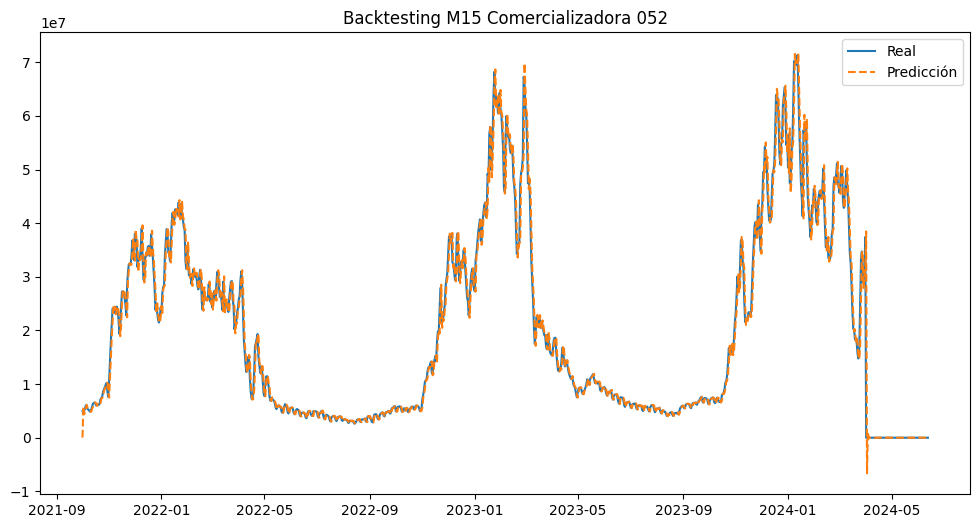

In [135]:
# Datos reales: Reparto_M15_052
reales_M15_052 = np.array(Reparto_M15_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_052 = reales_M15_052 - predicciones_bayes_M15_052

# Ajustar modelo ARIMA para el residual (noise)
model_M15_052_arima = ARIMA(noise_M15_052, order=(1,1,1))
model_M15_052_fit = model_M15_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_052 = model_M15_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

# Calcular métricas de evaluación para el backtesting
mae_M15_052 = mean_absolute_error(reales_M15_052, predicciones_finales_M15_052)
rmse_M15_052 = np.sqrt(mean_squared_error(reales_M15_052, predicciones_finales_M15_052))

print(f"MAE M15_052: {mae_M15_052}")
print(f"RMSE M15_052: {rmse_M15_052}")

# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Real'], label='Real')
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 052')
plt.legend()
plt.show()


In [136]:
# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})
df_backtesting_M15_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,2.782983e+04
1,2021-10-02,4590586.0,5.792075e+06
2,2021-10-03,4991559.0,4.385154e+06
3,2021-10-04,5544540.0,5.090368e+06
4,2021-10-05,6046824.0,5.624558e+06


MAE N1_762: 1894.1109126970423
RMSE N1_762: 2620.64218809072


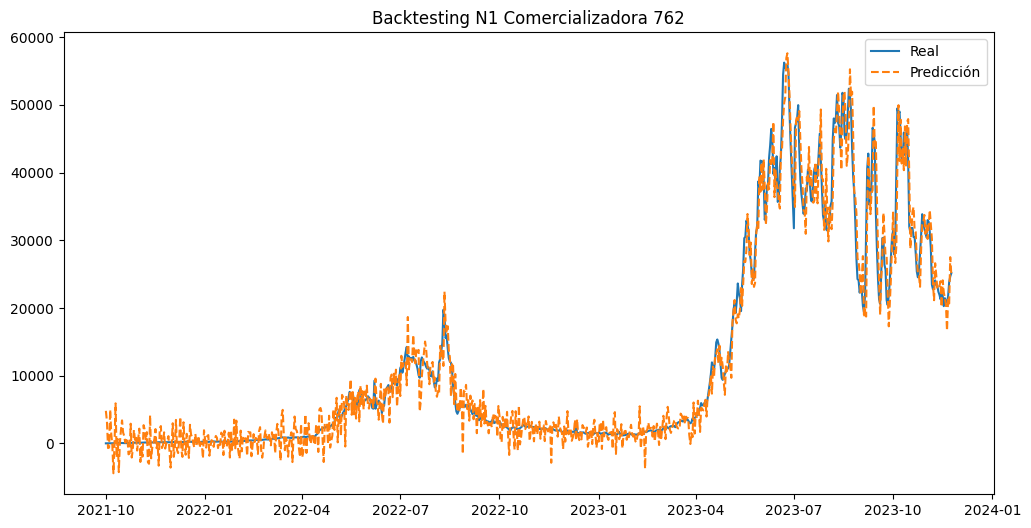

In [137]:
# Datos reales: Reparto_N1_762
reales_N1_762 = np.array(Reparto_N1_762)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_762 = reales_N1_762 - predicciones_bayes_N1_762

# Ajustar modelo ARIMA para el residual (noise)
model_N1_762_arima = ARIMA(noise_N1_762, order=(1,1,1))
model_N1_762_fit = model_N1_762_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_762 = model_N1_762_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

# Calcular métricas de evaluación para el backtesting
mae_N1_762 = mean_absolute_error(reales_N1_762, predicciones_finales_N1_762)
rmse_N1_762 = np.sqrt(mean_squared_error(reales_N1_762, predicciones_finales_N1_762))

print(f"MAE N1_762: {mae_N1_762}")
print(f"RMSE N1_762: {rmse_N1_762}")

# Crear un DataFrame con los resultados
df_backtesting_N1_762 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Real'], label='Real')
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 762')
plt.legend()
plt.show()


In [116]:
# Crear un DataFrame con los resultados
df_backtesting_N1_762= pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})
df_backtesting_N1_762.head(-5)

,Fecha,Real,Prediccion
0,2021-10-01,10.0,4810.807015
1,2021-10-02,11.0,3238.224976
2,2021-10-03,10.0,-683.426468
3,2021-10-04,16.0,-608.156350
4,2021-10-05,14.0,4992.054290
...,...,...,...
775,2023-11-15,22220.0,20158.826251
776,2023-11-16,21823.0,24083.407344
777,2023-11-17,20273.0,22300.697233
778,2023-11-18,21449.0,21508.119494
